# Мастерская Dota-2

**Описание проекта:** на основе предоставленного массива данных по всем характеристикам игры, доступным на определенный момент времени предсказать исход игры Dota-2

**Цель проекта:** Предсказать исход игры DOTA-2.

**Задачи проекта:** Построить модель, способную оценить вероятность победы команды Radiant. Качество работы модели оценивается с помощью метрики ROC-AUC. В идеале метрика должна быть выше 90%.

**План работы:**

1. Загрузка данных, изучение первичной информации.

2. Предобработка данных:
     - 2.1. Проверка на пропуски
     - 2.2. Проверка на явные дубликаты

3. Подготовка данных, создание дополнительных признаков
4. Подбор моделей
    - 4.1. Логистическая регрессия
    - 4.2. CatBoostClassifier
    - 4.3. RandomForestClassifier
5. Загрузка тестовых данных
6. Анализ признаков


## 1. Загрузка данных, изучение первичной информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np


from sklearn.linear_model import  LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Откроем файл train_features и выведем первые 5 строк таблицы
train_features = pd.read_csv('train_features.csv')
train_features.head(5)


,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,9c6b58e79e0d04d088b8a4f6ec6298e0,732,22,0,1,11,86,2,0,4,...,4.698640,0,0,1,0,0.000000,0,0,0,0
1,5bf625dc1c354662e6e5a7c0a65e6345,1291,22,7,9,16,74,2,2,4,...,1.532959,1,1,6,0,0.380952,0,1,3,4
2,ef9c4df32ba8677a5615026daf18ed81,1853,22,7,16,6,74,3,6,8,...,17.928955,4,2,7,0,0.379310,2,0,1,0
3,6e24ac63ba64b99ce45d2b3b1c2fe715,838,22,7,3,4,87,0,3,2,...,5.365387,0,0,4,0,0.272727,1,0,0,0
4,1133713ebbd98e4522a5fc6a2a546395,631,23,0,5,9,11,2,0,3,...,0.166602,0,0,0,0,0.666667,0,0,1,0


In [3]:
train_features.shape

(33723, 246)

In [4]:
#Выведем общую информацию по таблице train_features

train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33723 entries, 0 to 33722
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 63.3+ MB


В таблице 246 столбцов и 33723 строки. Из них 30 столбцов имеют тип данных float64, 215 - int64, один столбец(match_id_hash) - object. Сохраним названия столбцов в отдельный список.

In [5]:
# Откроем файл train_targets и выведем первые 5 строк таблицы

train_targets = pd.read_csv('train_targets.csv')
train_targets.head(5)

,match_id_hash,game_time,radiant_win,duration,time_remaining,next_roshan_team
0,a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
1,b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
2,6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
3,46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
4,b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [6]:
train_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33723 entries, 0 to 33722
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   match_id_hash     33723 non-null  object
 1   game_time         33723 non-null  int64 
 2   radiant_win       33723 non-null  bool  
 3   duration          33723 non-null  int64 
 4   time_remaining    33723 non-null  int64 
 5   next_roshan_team  21532 non-null  object
dtypes: bool(1), int64(3), object(2)
memory usage: 1.3+ MB


В таблице 6 столбцов и 33723 строки. Нас будут интересовать столбцы match_id_hash и radiant_win, пропусков в этих столбцах нет.

## 2. Предобработка данных.

### 2.1. Проверка на пропуски.


В таблице train_features 246 столбцов. Для того, чтобы проверить на пропуски каждый столбец, запустим цикл, который будет сравнивать количество записей в столбце с количеством строк в таблице и если оно меньше - выводить информацию о количестве записей в данном столбце.

In [7]:
columns_train_features = train_features.columns

In [8]:
for column in columns_train_features:
    if train_features[column].isna().sum()>0:
        print (column, train_features[column].isna().sum())
print ('Проверка выполнена')

Проверка выполнена


В таблице train_features пропусков в записях нет. Проверим таблицу train_targets

In [9]:
columns_train_targets=train_targets.columns

In [10]:
for column in columns_train_targets:
    if train_targets[column].isna().sum()>0:
        print (column, train_targets[column].isna().sum())
print ('Проверка выполнена')

next_roshan_team 12191
Проверка выполнена


В таблице train_targets есть пропуски в столбце next_roshan_team.

### 2.2. Проверка на дубликаты.

In [11]:
train_features.duplicated().sum()

0

In [12]:
train_targets.duplicated().sum()

0

Строк с дубликатами в таблицах с данными нет.

Мы выполнили проверку предоставленных таблиц на пропуски и явные дубликаты. В тренировочной таблице train_features пропусков и дубликатов нет. В таблице train_targets есть пропуски в столбце next_roshan_team, но этот столбец, исходя из поставленной задачи, для нас не актуален, поэтому оставим данные в исходном виде.

## 3. Подготовка данных, создание дополнительных признаков.

На основе таблицы train_features посчитаем общую сумму золота для каждой из двух команд

In [13]:
def sum_features(data):

    data['r_gold'] = data[['r1_gold', 'r2_gold', 'r3_gold', 'r4_gold', 'r5_gold']].sum(axis=1)
    data['d_gold'] = data[['d1_gold', 'd2_gold', 'd3_gold', 'd4_gold', 'd5_gold']].sum(axis=1) 
    
    return data     
    

In [14]:
new_train_features = sum_features(train_features)
new_train_features.shape

(33723, 248)

In [15]:
new_train_features.shape

(33723, 248)

На основе предоставленного jsonl файла, была дополнительно создана таблица items, в которой для каждого игрока подсчитано количество использованных в игре магических предметов (item_uses). Загрузим эту таблицу.

In [16]:
items = pd.read_csv('items.csv')
items.head()

,match_id_hash,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
0,a400b8f29dece5f4d266f49f1ae2e98a,2.0,9.0,5.0,3.0,1.0,4.0,0.0,1.0,4.0,3.0
1,b9c57c450ce74a2af79c9ce96fac144d,34.0,22.0,19.0,16.0,12.0,8.0,14.0,21.0,15.0,9.0
2,6db558535151ea18ca70a6892197db41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,46a0ddce8f7ed2a8d9bd5edcbb925682,10.0,17.0,16.0,7.0,12.0,26.0,10.0,11.0,7.0,11.0
4,b1b35ff97723d9b7ade1c9c3cf48f770,5.0,6.0,7.0,11.0,19.0,6.0,11.0,5.0,7.0,6.0


In [17]:
items.shape

(33723, 11)

Соединим данную таблицу с new_train_features и добавим к ним целевой признак.

In [18]:
new_train = new_train_features.merge(items,on='match_id_hash', how='left')
new_train.shape

(33723, 258)

In [19]:
data_train = new_train.merge(train_targets[['radiant_win', 'match_id_hash']], on='match_id_hash', how='left')
data_train = data_train.set_index('match_id_hash')
data_train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum,radiant_win
match_id_hash,,,,,,,,,,,,,,,,,,,,,
9c6b58e79e0d04d088b8a4f6ec6298e0,732,22,0,1,11,86,2,0,4,2,...,16.0,11.0,8.0,34.0,13.0,15.0,7.0,20.0,9.0,True
5bf625dc1c354662e6e5a7c0a65e6345,1291,22,7,9,16,74,2,2,4,20,...,14.0,34.0,19.0,61.0,38.0,38.0,11.0,67.0,27.0,False
ef9c4df32ba8677a5615026daf18ed81,1853,22,7,16,6,74,3,6,8,13,...,88.0,55.0,126.0,131.0,61.0,28.0,91.0,201.0,125.0,False
6e24ac63ba64b99ce45d2b3b1c2fe715,838,22,7,3,4,87,0,3,2,2,...,29.0,21.0,20.0,25.0,13.0,14.0,37.0,17.0,14.0,False
1133713ebbd98e4522a5fc6a2a546395,631,23,0,5,9,11,2,0,3,7,...,20.0,48.0,31.0,12.0,10.0,15.0,7.0,10.0,16.0,True


Разделим таблицы на целевой и входящий признаки.

In [20]:
X = data_train.drop('radiant_win', axis=1)
y = data_train['radiant_win']
X.shape, y.shape

((33723, 257), (33723,))

Создадим список колонок с id игроков, эти данные преобразовывать не будем.

In [21]:
id_cols = ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id',
             'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 
             'd4_hero_id', 'd5_hero_id']

Разделим таблицу с входящими признаками. Числовые колонки преобразуем с помощью MinMaxScaler

In [22]:
X_num_cols = X.drop(id_cols, axis=1)
num_cols=X_num_cols.columns
X_num_cols.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
match_id_hash,,,,,,,,,,,,,,,,,,,,,
9c6b58e79e0d04d088b8a4f6ec6298e0,732,22,0,1,11,2,0,4,2,2403,...,13.0,16.0,11.0,8.0,34.0,13.0,15.0,7.0,20.0,9.0
5bf625dc1c354662e6e5a7c0a65e6345,1291,22,7,9,16,2,2,4,20,7227,...,17.0,14.0,34.0,19.0,61.0,38.0,38.0,11.0,67.0,27.0
ef9c4df32ba8677a5615026daf18ed81,1853,22,7,16,6,3,6,8,13,14970,...,20.0,88.0,55.0,126.0,131.0,61.0,28.0,91.0,201.0,125.0
6e24ac63ba64b99ce45d2b3b1c2fe715,838,22,7,3,4,0,3,2,2,2395,...,15.0,29.0,21.0,20.0,25.0,13.0,14.0,37.0,17.0,14.0
1133713ebbd98e4522a5fc6a2a546395,631,23,0,5,9,2,0,3,7,7562,...,19.0,20.0,48.0,31.0,12.0,10.0,15.0,7.0,10.0,16.0


In [23]:
X_id_cols = X[id_cols]
X_id_cols.head()

,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id
match_id_hash,,,,,,,,,,
9c6b58e79e0d04d088b8a4f6ec6298e0,86,94,2,75,11,114,8,31,14,74
5bf625dc1c354662e6e5a7c0a65e6345,74,32,27,14,95,35,101,99,8,110
ef9c4df32ba8677a5615026daf18ed81,74,53,50,32,94,49,40,27,41,19
6e24ac63ba64b99ce45d2b3b1c2fe715,87,11,50,108,8,23,97,43,68,41
1133713ebbd98e4522a5fc6a2a546395,11,101,104,44,14,48,97,71,33,35


In [24]:
scaler = MinMaxScaler()

In [25]:
X_train_num_cols = scaler.fit_transform(X_num_cols)


In [26]:
X_train_num_cols=pd.DataFrame(X_train_num_cols, columns=num_cols)
X_train_num_cols.shape

(33723, 247)

In [27]:
X_train_num_cols.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
0,0.154365,0.952381,0.0,0.023256,0.037801,0.06250,0.000000,0.100,0.023810,0.041088,...,0.012127,0.011808,0.009973,0.006033,0.033663,0.013978,0.011755,0.007042,0.021008,0.007550
1,0.272248,0.952381,1.0,0.209302,0.054983,0.06250,0.074074,0.100,0.238095,0.123642,...,0.015858,0.010332,0.030825,0.014329,0.060396,0.040860,0.029781,0.011066,0.070378,0.022651
2,0.390763,0.952381,1.0,0.372093,0.020619,0.09375,0.222222,0.200,0.154762,0.256148,...,0.018657,0.064945,0.049864,0.095023,0.129703,0.065591,0.021944,0.091549,0.211134,0.104866
3,0.176719,0.952381,1.0,0.069767,0.013746,0.00000,0.111111,0.050,0.023810,0.040951,...,0.013993,0.021402,0.019039,0.015083,0.024752,0.013978,0.010972,0.037223,0.017857,0.011745
4,0.133066,1.000000,0.0,0.116279,0.030928,0.06250,0.000000,0.075,0.083333,0.129375,...,0.017724,0.014760,0.043518,0.023379,0.011881,0.010753,0.011755,0.007042,0.010504,0.013423


In [28]:
X_id_cols= X_id_cols.reset_index()
X_id_cols.head()

,match_id_hash,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id
0,9c6b58e79e0d04d088b8a4f6ec6298e0,86,94,2,75,11,114,8,31,14,74
1,5bf625dc1c354662e6e5a7c0a65e6345,74,32,27,14,95,35,101,99,8,110
2,ef9c4df32ba8677a5615026daf18ed81,74,53,50,32,94,49,40,27,41,19
3,6e24ac63ba64b99ce45d2b3b1c2fe715,87,11,50,108,8,23,97,43,68,41
4,1133713ebbd98e4522a5fc6a2a546395,11,101,104,44,14,48,97,71,33,35


In [29]:
X_train = pd.concat([X_id_cols, X_train_num_cols],axis=1)
X_train = X_train.set_index('match_id_hash')
X_train.shape

(33723, 257)

In [30]:
X_train.head()

,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
match_id_hash,,,,,,,,,,,,,,,,,,,,,
9c6b58e79e0d04d088b8a4f6ec6298e0,86,94,2,75,11,114,8,31,14,74,...,0.012127,0.011808,0.009973,0.006033,0.033663,0.013978,0.011755,0.007042,0.021008,0.007550
5bf625dc1c354662e6e5a7c0a65e6345,74,32,27,14,95,35,101,99,8,110,...,0.015858,0.010332,0.030825,0.014329,0.060396,0.040860,0.029781,0.011066,0.070378,0.022651
ef9c4df32ba8677a5615026daf18ed81,74,53,50,32,94,49,40,27,41,19,...,0.018657,0.064945,0.049864,0.095023,0.129703,0.065591,0.021944,0.091549,0.211134,0.104866
6e24ac63ba64b99ce45d2b3b1c2fe715,87,11,50,108,8,23,97,43,68,41,...,0.013993,0.021402,0.019039,0.015083,0.024752,0.013978,0.010972,0.037223,0.017857,0.011745
1133713ebbd98e4522a5fc6a2a546395,11,101,104,44,14,48,97,71,33,35,...,0.017724,0.014760,0.043518,0.023379,0.011881,0.010753,0.011755,0.007042,0.010504,0.013423


## 4. Подбор моделей.

### 4.1. LogisticRegression

In [31]:
# Зададим random_state
RANDOM_STATE = 23

In [32]:
#Зададим модель логистической регрессии:
model_lr = LogisticRegression(random_state = RANDOM_STATE)

In [33]:
#Зададим перебор гиперпараметров
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': range (1, 6),
    'solver': ['liblinear', 'saga']
}

In [34]:
# Запустим поиск с помощью RandomSearchCV
rs_lr=RandomizedSearchCV(
model_lr,
param_lr,
n_jobs=-1,
cv=5,
scoring='roc_auc')

In [35]:
rs_lr.fit(X_train, y)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=23),
                   n_jobs=-1,
                   param_distributions={'C': range(1, 6),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='roc_auc')

In [36]:
# Выведем лучший результат и модель
print('Лучшая модель Логистической регрессии с параметрами:', rs_lr.best_params_)
print('Результат метрики ROC-AUC лучшей модели при кросс-валидации:', rs_lr.best_score_)

Лучшая модель Логистической регрессии с параметрами: {'solver': 'liblinear', 'penalty': 'l1', 'C': 2}
Результат метрики ROC-AUC лучшей модели при кросс-валидации: 0.8111990785979927


### 4.2. CatBoostClassifier

In [37]:
# Зададим модель
model_2 = CatBoostClassifier(loss_function = 'Logloss', iterations = 150)

In [38]:
#Зададим гиперпараметры к перебору
param_cbc={
    'depth':range (6, 12),
    'learning_rate': [0.1, 0.3, 0.5, 0.7]
}

In [39]:
# Запустим поиск с помощью RandomizedSearchCV
rs_cbc=RandomizedSearchCV(
model_2,
param_cbc,
n_jobs=-1,
cv=5,
scoring='roc_auc',
random_state = RANDOM_STATE
)

In [40]:
rs_cbc.fit(X_train, y, verbose=10)

0:	learn: 0.6781524	total: 363ms	remaining: 54.1s
10:	learn: 0.5998910	total: 2.37s	remaining: 29.9s
20:	learn: 0.5708512	total: 4.43s	remaining: 27.2s
30:	learn: 0.5552453	total: 6.42s	remaining: 24.7s
40:	learn: 0.5422333	total: 8.31s	remaining: 22.1s
50:	learn: 0.5327690	total: 10.2s	remaining: 19.8s
60:	learn: 0.5258094	total: 12.1s	remaining: 17.7s
70:	learn: 0.5193219	total: 14.1s	remaining: 15.7s
80:	learn: 0.5131416	total: 16s	remaining: 13.6s
90:	learn: 0.5067699	total: 17.8s	remaining: 11.5s
100:	learn: 0.5011858	total: 19.7s	remaining: 9.54s
110:	learn: 0.4953793	total: 21.4s	remaining: 7.53s
120:	learn: 0.4893181	total: 23.2s	remaining: 5.55s
130:	learn: 0.4828345	total: 25s	remaining: 3.62s
140:	learn: 0.4768766	total: 26.7s	remaining: 1.71s
149:	learn: 0.4714980	total: 28.4s	remaining: 0us


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001BB08C14B90>,
                   n_jobs=-1,
                   param_distributions={'depth': range(6, 12),
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7]},
                   random_state=23, scoring='roc_auc')

In [41]:
print('Лучшая модель градиентного спуска с гиперпараметрами:', rs_cbc.best_params_)
print('Результат метрики ROC-AUC лучшей модели при кросс-валидации:', rs_cbc.best_score_)

Лучшая модель градиентного спуска с гиперпараметрами: {'learning_rate': 0.1, 'depth': 7}
Результат метрики ROC-AUC лучшей модели при кросс-валидации: 0.7963502853453346


### 4.3. RandomForestClassifier

In [42]:
model_3 = RandomForestClassifier(random_state=RANDOM_STATE)

In [43]:
param_rf = {
    'max_depth':range(10,18),
    'criterion':['gini', 'entropy', 'log_loss']
}

In [44]:
rs_rf=RandomizedSearchCV(
model_3,
param_rf,
n_jobs=-1,
cv=5,
scoring='roc_auc',
random_state = RANDOM_STATE
)

In [45]:
rs_rf.fit(X_train, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(10, 18)},
                   random_state=23, scoring='roc_auc')

In [46]:
print('Лучшая модель случайного леса с гиперпараметрами:', rs_rf.best_params_)
print('Результат метрики ROC-AUC лучшей модели при кросс-валидации:', rs_rf.best_score_)

Лучшая модель случайного леса с гиперпараметрами: {'max_depth': 12, 'criterion': 'log_loss'}
Результат метрики ROC-AUC лучшей модели при кросс-валидации: 0.7846539971052581


## 5. Загрузка тестовых данных

In [47]:
test_features = pd.read_csv('test_features_202410231811.csv')
test_features.head()

,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,ee84861e709fc9cf5d48ba0f04b7f43b,1807,22,7,17,12,32,2,5,14,...,12.174799,0,0,1,0,0.650000,0,0,0,0
1,a9475ee47c8a10d6cf37c1461814653e,2591,22,7,13,106,119,17,9,16,...,31.994320,0,0,12,0,0.553191,1,0,0,0
2,b56ea18db1408fc68263757232c1facb,958,22,7,4,0,53,5,2,3,...,20.528862,0,0,4,0,0.600000,0,0,4,2
3,9587640246910f0e1b033a6c8f6d8211,2092,4,0,14,2,44,8,8,8,...,27.558594,0,0,6,0,0.514286,1,0,0,0
4,3eb93fbd9056ebdb52ffff84e6c3664a,554,22,7,1,0,95,0,0,3,...,11.663805,6,2,6,0,1.000000,0,0,3,3


In [48]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 11.2+ MB


Тестовые данные содержат 5952 строки и 246 столбцов. Добавим столбцы с общей суммой золота по командам.

Загрузим файл с дополнительно посчитанными волшебными предметами.

In [49]:
new_test_features = sum_features(test_features)
new_test_features.shape

(5952, 248)

In [50]:
test_item = pd.read_csv('test_item.csv')
test_item.head()

,match_id_hash,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
0,4b6e4e511d399180776d0f23984466b2,24.0,85.0,60.0,89.0,277.0,68.0,76.0,47.0,32.0,44.0
1,64ed11373bcf2cfea7a60ede637b70d2,29.0,63.0,89.0,15.0,31.0,64.0,58.0,80.0,21.0,52.0
2,7174c98d3b2e4ac2b9f5947935cbdd52,18.0,8.0,17.0,34.0,14.0,28.0,36.0,10.0,15.0,31.0
3,86d60b73cbfdbf0a6c291dad12d967f0,43.0,10.0,40.0,15.0,32.0,115.0,28.0,13.0,13.0,48.0
4,fb5c712c74f8317689e7082416b90b77,34.0,16.0,47.0,13.0,30.0,40.0,59.0,39.0,12.0,190.0


In [51]:
test_item.shape

(5952, 11)

Объединим обе таблицы

In [52]:
new_test = new_test_features.merge(test_item,on='match_id_hash', how='left')
new_test = new_test.set_index('match_id_hash')
new_test.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
match_id_hash,,,,,,,,,,,,,,,,,,,,,
ee84861e709fc9cf5d48ba0f04b7f43b,1807,22,7,17,12,32,2,5,14,0,...,14.0,96.0,69.0,155.0,143.0,59.0,49.0,65.0,35.0,30.0
a9475ee47c8a10d6cf37c1461814653e,2591,22,7,13,106,119,17,9,16,4,...,62.0,108.0,555.0,70.0,36.0,86.0,122.0,40.0,92.0,103.0
b56ea18db1408fc68263757232c1facb,958,22,7,4,0,53,5,2,3,10,...,54.0,27.0,51.0,13.0,35.0,21.0,19.0,59.0,39.0,24.0
9587640246910f0e1b033a6c8f6d8211,2092,4,0,14,2,44,8,8,8,10,...,100.0,19.0,32.0,32.0,12.0,68.0,100.0,44.0,24.0,31.0
3eb93fbd9056ebdb52ffff84e6c3664a,554,22,7,1,0,95,0,0,3,17,...,24.0,9.0,8.0,4.0,9.0,7.0,8.0,4.0,11.0,18.0


In [53]:
new_test.shape

(5952, 257)

Подготовим числовые столбцы.

In [54]:
X_test_num_cols = new_test.drop(id_cols, axis=1)
X_test_num_cols.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
match_id_hash,,,,,,,,,,,,,,,,,,,,,
ee84861e709fc9cf5d48ba0f04b7f43b,1807,22,7,17,12,2,5,14,0,10093,...,14.0,96.0,69.0,155.0,143.0,59.0,49.0,65.0,35.0,30.0
a9475ee47c8a10d6cf37c1461814653e,2591,22,7,13,106,17,9,16,4,17261,...,62.0,108.0,555.0,70.0,36.0,86.0,122.0,40.0,92.0,103.0
b56ea18db1408fc68263757232c1facb,958,22,7,4,0,5,2,3,10,5815,...,54.0,27.0,51.0,13.0,35.0,21.0,19.0,59.0,39.0,24.0
9587640246910f0e1b033a6c8f6d8211,2092,4,0,14,2,8,8,8,10,14347,...,100.0,19.0,32.0,32.0,12.0,68.0,100.0,44.0,24.0,31.0
3eb93fbd9056ebdb52ffff84e6c3664a,554,22,7,1,0,0,0,3,17,2873,...,24.0,9.0,8.0,4.0,9.0,7.0,8.0,4.0,11.0,18.0


In [55]:
X_test_num_cols = scaler.transform(X_test_num_cols)

In [56]:
X_test_num_cols=pd.DataFrame(X_test_num_cols, columns=num_cols)
X_test_num_cols.shape

(5952, 247)

In [57]:
X_test_id_cols = new_test[id_cols].reset_index()
X_test_id_cols.head()

,match_id_hash,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id
0,ee84861e709fc9cf5d48ba0f04b7f43b,32,15,86,101,109,76,108,95,103,10
1,a9475ee47c8a10d6cf37c1461814653e,119,44,34,36,92,14,28,30,59,22
2,b56ea18db1408fc68263757232c1facb,53,3,72,16,47,120,100,22,109,5
3,9587640246910f0e1b033a6c8f6d8211,44,49,6,18,1,91,4,101,51,114
4,3eb93fbd9056ebdb52ffff84e6c3664a,95,69,87,25,23,104,54,31,43,21


In [58]:
X_test = pd.concat([X_test_id_cols, X_test_num_cols],axis=1).set_index('match_id_hash')
X_test.shape

(5952, 257)

In [59]:
X_test.head()

,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id,...,r1_item_sum,r2_item_sum,r3_item_sum,r4_item_sum,r5_item_sum,d1_item_sum,d2_item_sum,d3_item_sum,d4_item_sum,d5_item_sum
match_id_hash,,,,,,,,,,,,,,,,,,,,,
ee84861e709fc9cf5d48ba0f04b7f43b,32,15,86,101,109,76,108,95,103,10,...,0.013060,0.070849,0.062557,0.116893,0.141584,0.063441,0.038401,0.065392,0.036765,0.025168
a9475ee47c8a10d6cf37c1461814653e,119,44,34,36,92,14,28,30,59,22,...,0.057836,0.079705,0.503173,0.052790,0.035644,0.092473,0.095611,0.040241,0.096639,0.086409
b56ea18db1408fc68263757232c1facb,53,3,72,16,47,120,100,22,109,5,...,0.050373,0.019926,0.046238,0.009804,0.034653,0.022581,0.014890,0.059356,0.040966,0.020134
9587640246910f0e1b033a6c8f6d8211,44,49,6,18,1,91,4,101,51,114,...,0.093284,0.014022,0.029012,0.024133,0.011881,0.073118,0.078370,0.044266,0.025210,0.026007
3eb93fbd9056ebdb52ffff84e6c3664a,95,69,87,25,23,104,54,31,43,21,...,0.022388,0.006642,0.007253,0.003017,0.008911,0.007527,0.006270,0.004024,0.011555,0.015101


Предскажем целевой признак тестовой выборки с помощью лучшей модели

In [60]:
y_pred = rs_lr.best_estimator_.predict(X_test)

In [61]:
column=['Target']
y_pred = pd.DataFrame(y_pred, columns=column).astype('int64')
y_pred.head()

,Target
0,1
1,0
2,1
3,1
4,0


In [62]:
ind = test_features['match_id_hash']
ind.head()

0    ee84861e709fc9cf5d48ba0f04b7f43b
1    a9475ee47c8a10d6cf37c1461814653e
2    b56ea18db1408fc68263757232c1facb
3    9587640246910f0e1b033a6c8f6d8211
4    3eb93fbd9056ebdb52ffff84e6c3664a
Name: match_id_hash, dtype: object

In [63]:
predictions = pd.concat([ind, y_pred], axis=1)
predictions = predictions.rename(columns = {'match_id_hash':'ID',
                                           'predictions':'Target'})
predictions.head()

,ID,Target
0,ee84861e709fc9cf5d48ba0f04b7f43b,1
1,a9475ee47c8a10d6cf37c1461814653e,0
2,b56ea18db1408fc68263757232c1facb,1
3,9587640246910f0e1b033a6c8f6d8211,1
4,3eb93fbd9056ebdb52ffff84e6c3664a,0


In [64]:
predictions.to_csv('prediction.csv', index=False)

## 6. Анализ важности признаков

In [65]:
explainer = shap.LinearExplainer(rs_lr.best_estimator_, X_train)

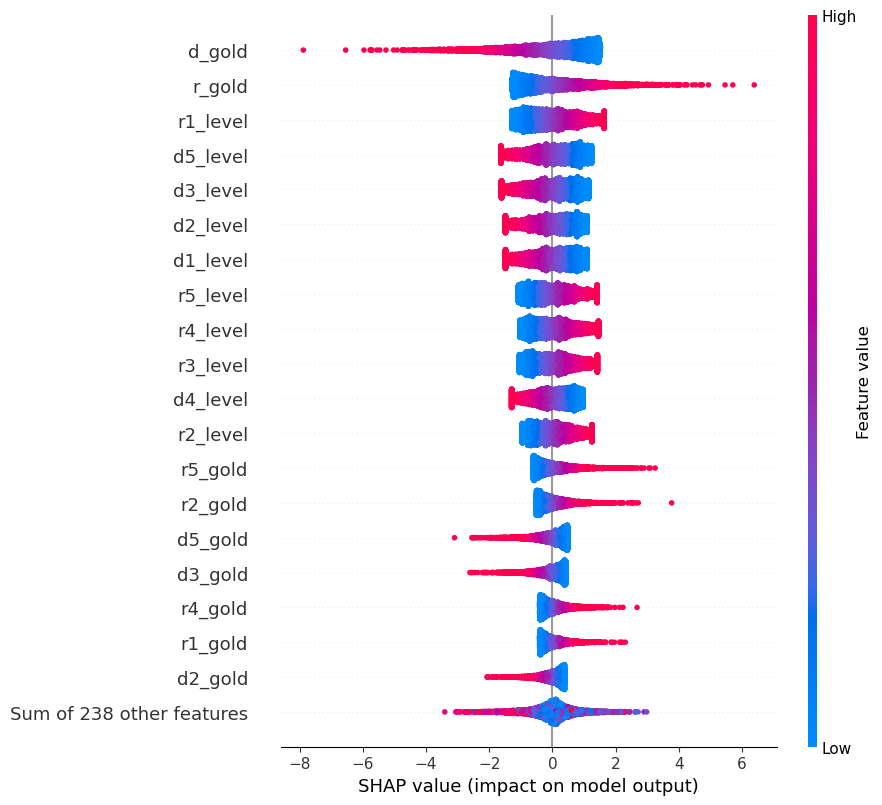

In [66]:
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=20)

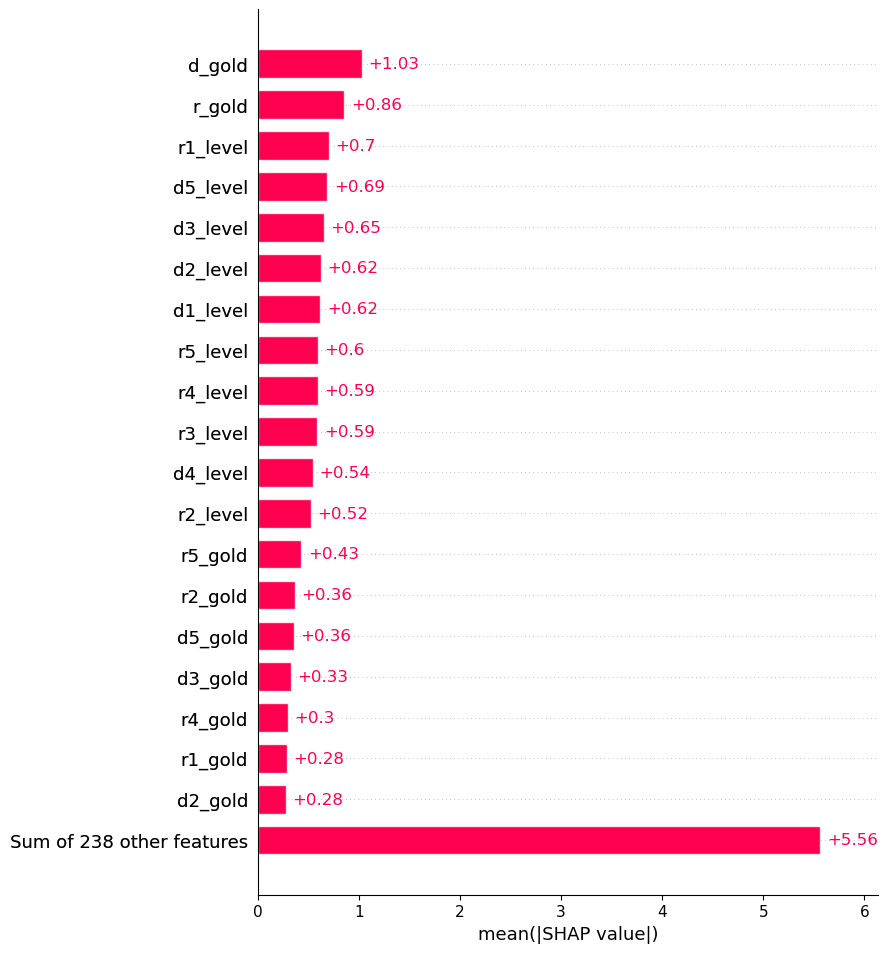

In [67]:
shap.plots.bar(shap_values, max_display=20) 

Золото является одним из главных признаков для принятия моделью решения. Низкий уровень золота в команде противников является для модели веской причиной в пользу победы Radiant. И наоборот, большое количество золота у Radiant говорит в пользу предсказания ее победы. Так же важными оказываются для модели уровни игроков. Высокий уровень игроков Radiant позволяет модели предсказать их победу, высокий уровень Dare - склоняет модель к предсказанию поражения Radiant.

Значение roc_auc лучшей модели на тестовой выборке равно 0,73 - результат говорит о том, что модель еще несовершенна и требует дальнейшей работы.